In [1]:
import torch
import torchvision
import torch
import torchvision
import numpy as np
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torch.utils.data import DataLoader
import random
from types import ModuleType

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
c = ModuleType("contstants")
# ------------------------------------- Constants -------------------------------------
c.Training_Data = 0
c.Model = 1
c.Client_Accuracies = 2
c.Client_Performance_Scores = 3
c.Current_Performance_Score = 4
c.Client_Age = 5
c.Optimizer = 6

NUM_CLIENTS = 100

"""
+---------------------------------------------------------------------------------+
|    ____ ___ _____ _    ____       _  ___    ____        _                 _     |
|   / ___|_ _|  ___/ \  |  _ \     / |/ _ \  |  _ \  __ _| |_ __ _ ___  ___| |_   |
|  | |    | || |_ / _ \ | |_) |____| | | | | | | | |/ _` | __/ _` / __|/ _ \ __|  |
|  | |___ | ||  _/ ___ \|  _ <_____| | |_| | | |_| | (_| | || (_| \__ \  __/ |_   |
|   \____|___|_|/_/   \_\_| \_\    |_|\___/  |____/ \__,_|\__\__,_|___/\___|\__|  |
+---------------------------------------------------------------------------------+
----------------------------------------------------------------------------------
+-----------------------+
|   _____ ___________   |
|  |_   _|_   _|  _  \  |
|    | |   | | | | | |  |
|    | |   | | | | | |  |
|   _| |_ _| |_| |/ /   |
|   \___/ \___/|___/    |
+-----------------------+

"""
def convert(set):
    return [*set,]

def iid_distribution_CIFAR(NUM_CLIENTS, trainset):
    # Define the transform to apply to the dataset
    client_map = dict()
    global_model = CIFAR10_CNN().to(device)
    models = [CIFAR10_CNN().to(device) for _ in range(NUM_CLIENTS)]

    for model in models:
        model.load_state_dict(global_model.state_dict())
    
    opt = [optim.SGD(model.parameters(), lr=0.215) for model in models]

    clients_with_data = cifar_iid(trainset, NUM_CLIENTS)
    # Create a list to store the data loaders
    train_data_loaders = []

    for i in range(NUM_CLIENTS):
        cli_train = clients_with_data[i]
        train_data_loaders.append(cli_train)

    for client in range(NUM_CLIENTS):
        random_score = random.random()
        client_map.update({client: [train_data_loaders[client].astype(int), models[client], [], [random_score], random_score, 0, opt[client]]})
    
    return client_map, global_model

def cifar_iid(dataset, num_users):
    """
    Sample I.I.D. client data from CIFAR10 dataset
    :param dataset:
    :param num_users:
    :return: dict of image index
    """
    num_items = int(len(dataset)/num_users)
    dict_users, all_idxs = {}, [i for i in range(len(dataset))]
    for i in range(num_users):
        dict_users[i] = set(np.random.choice(all_idxs, num_items,
                                             replace=False))
        all_idxs = list(set(all_idxs) - dict_users[i])
    
    for i in range(num_users):
        dict_users[i] = np.array(convert(dict_users[i]))

    return dict_users

""""
+---------------------------------------------------------------------+
|   __  __ _   _ ___ ____ _____   ____        _                 _     |
|  |  \/  | \ | |_ _/ ___|_   _| |  _ \  __ _| |_ __ _ ___  ___| |_   |
|  | |\/| |  \| || |\___ \ | |   | | | |/ _` | __/ _` / __|/ _ \ __|  |
|  | |  | | |\  || | ___) || |   | |_| | (_| | || (_| \__ \  __/ |_   |
|  |_|  |_|_| \_|___|____/ |_|   |____/ \__,_|\__\__,_|___/\___|\__|  |
+---------------------------------------------------------------------+

+-----------------------+
|   _____ ___________   |
|  |_   _|_   _|  _  \  |
|    | |   | | | | | |  |
|    | |   | | | | | |  |
|   _| |_ _| |_| |/ /   |
|   \___/ \___/|___/    |
+-----------------------+
"""


def iid_distribution_MNIST(NUM_CLIENTS, trainset):
    # Define the transform to apply to the dataset
    client_map = dict()
    clients_with_data = mnist_iid(trainset, NUM_CLIENTS)
    global_model = MNIST_MLP().to(device)
    models = [MNIST_MLP().to(device) for _ in range(NUM_CLIENTS)]
    for model in models:
        model.load_state_dict(global_model.state_dict())
    
    opt = [optim.SGD(model.parameters(), lr=0.15) for model in models]
    # Create a list to store the data loaders
    train_data_loaders = []

    for i in range(NUM_CLIENTS):
        cli_train = clients_with_data[i]
        train_data_loaders.append(cli_train)

    for i in range(NUM_CLIENTS):
        random_score = random.random()
        client_map.update({i: [train_data_loaders[i].astype(int), models[i], [], [random_score], random_score, 0, opt[i]]})
    
    return client_map, global_model

def mnist_iid(dataset, num_users):
    """
    Sample I.I.D. client data from MNIST dataset
    :param dataset:
    :param num_users:
    :return: dict of image index
    """
    num_items = int(len(dataset)/num_users)
    dict_users, all_idxs = {}, [i for i in range(len(dataset))]
    for i in range(num_users):
        dict_users[i] = set(np.random.choice(all_idxs, num_items,
                                             replace=False))
        all_idxs = list(set(all_idxs) - dict_users[i])
    
    for i in range(num_users):
        dict_users[i] = np.array(convert(dict_users[i]))
    
    return dict_users

"""
+---------------------------------------------+
|   _   _                 _____ ___________   |
|  | \ | |               |_   _|_   _|  _  \  |
|  |  \| | ___  _ __ ______| |   | | | | | |  |
|  | . ` |/ _ \| '_ \______| |   | | | | | |  |
|  | |\  | (_) | | | |    _| |_ _| |_| |/ /   |
|  \_| \_/\___/|_| |_|    \___/ \___/|___/    |
+---------------------------------------------+
"""
def non_iid_distribution_MNIST(NUM_CLIENTS, trainset):
    # Define the classes to include in each data loader
    client_map = dict()
    global_model = MNIST_MLP().to(device)
    models = [MNIST_MLP().to(device) for _ in range(NUM_CLIENTS)]

    for model in models:
        model.load_state_dict(global_model.state_dict())
    
    opt = [optim.SGD(model.parameters(), lr=0.15) for model in models]
    # Create a list to store the data loaders
    train_data_loaders = []
    # Load the MNIST dataset
    clients_with_shards = mnist_noniid(trainset, NUM_CLIENTS, 2)
    # Create a list to store the data loaders
    train_data_loaders = []

    for i in range(NUM_CLIENTS):
        cli_train= clients_with_shards[i]
        train_data_loaders.append(cli_train)
 
    
    for client in range(NUM_CLIENTS):
        random_score = random.random()
        client_map.update({client: [train_data_loaders[client].astype(int), model[client], [], [random_score], random_score, 0, opt[client]]})
    
    return client_map, global_model

def mnist_noniid(dataset, num_users, shards_per_cli):
    """
    Sample non-I.I.D client data from MNIST dataset
    :param dataset:
    :param num_users:
    :return:
    """
    num_shards = num_users * shards_per_cli
    num_imgs = int(len(dataset) / num_shards)
    idx_shard = [i for i in range(num_shards)]
    dict_users = {i: np.array([]) for i in range(num_users)}
    idxs = np.arange(num_shards*num_imgs)
    labels = dataset.targets.numpy()
    
    # sort labels
    idxs_labels = np.vstack((idxs, labels))
    idxs_labels = idxs_labels[:, idxs_labels[1, :].argsort()]
    idxs = idxs_labels[0, :]

    # divide and assign 2 shards/client
    for i in range(num_users):
        rand_set = set(np.random.choice(idx_shard, 2, replace=False))
        idx_shard = list(set(idx_shard) - rand_set)
        for rand in rand_set:
            dict_users[i] = np.concatenate(
                (dict_users[i], idxs[rand*num_imgs:(rand+1)*num_imgs]), axis=0)
    return dict_users

"""
+---------------------------------------------------------------------------+
|   _   _                      _   _   _      _                      _      |
|  | \ | |                    | | | \ | |    | |                    | |     |
|  |  \| | ___ _   _ _ __ __ _| | |  \| | ___| |___      _____  _ __| | __  |
|  | . ` |/ _ \ | | | '__/ _` | | | . ` |/ _ \ __\ \ /\ / / _ \| '__| |/ /  |
|  | |\  |  __/ |_| | | | (_| | | | |\  |  __/ |_ \ V  V / (_) | |  |   <   |
|  \_| \_/\___|\__,_|_|  \__,_|_| \_| \_/\___|\__| \_/\_/ \___/|_|  |_|\_\  |
+---------------------------------------------------------------------------+
"""
# ------------------------------------- MLP MNIST -------------------------------------
class MNIST_MLP(nn.Module):
    def __init__(self):
        super(MNIST_MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
    
    def forward(self, x):
        x = x.view(-1, 28*28) # Flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
# ------------------------------------- CNN CIFAR-10 -------------------------------------
class CIFAR10_CNN(nn.Module):
    def __init__(self):
        super(CIFAR10_CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.softmax(x)
        return x


In [2]:
def initialize_clients(NUM_CLIENTS, dataset, distribution, trainset):
    if dataset == 'MNIST':
        if distribution == 'iid':
            client_map = iid_distribution_MNIST(NUM_CLIENTS, trainset)
        else:
            client_map = non_iid_distribution_MNIST(NUM_CLIENTS, trainset)
    else:
        if distribution == 'iid':
            client_map = iid_distribution_CIFAR(NUM_CLIENTS, trainset)
    
    return client_map

In [3]:
def update_performance(client_map, selected_clients, threshold):
    for client in client_map.keys():
        if client in selected_clients:
            client_accuracies = client_map[client][c.Client_Accuracies]
            mean_acc = sum(client_accuracies) / len(client_accuracies)
            varience = sum([((x - mean_acc) ** 2) for x in client_accuracies]) / (len(client_accuracies))
            if varience > threshold:
                updated_score = client_map[client][c.Current_Performance_Score] + 1.0    
            else:
                updated_score = client_map[client][c.Current_Performance_Score]
        else:
                updated_score = client_map[client][c.Current_Performance_Score] 
        mean_performance_score = (sum(client_map[client][c.Client_Performance_Scores])+updated_score) / len(client_map[client][c.Client_Performance_Scores])
        client_map[client][c.Current_Performance_Score] = mean_performance_score

In [4]:
def update_age(client_map, selected_clients):
    for client in client_map.keys():
        if client in selected_clients:
            client_map[client][c.Client_Age] = 0
        else:
            client_map[client][c.Client_Age] = client_map[client][c.Client_Age]**2 + 1      

In [5]:
def train_and_test_client(client_map, selected_clients, local_epochs, trainset, test_loader, global_model, performance_threshold):
    for client in selected_clients:
        client_map[client][c.Model].load_state_dict(global_model.state_dict())
        model = client_map[client][c.Model]
        model.train()
        train_loader_ind = client_map[client][c.Training_Data]
        train_loader = DataLoader(trainset, batch_size=30, sampler=train_loader_ind)
        criterion = nn.CrossEntropyLoss()
        optimizer = client_map[client][c.Optimizer]
        for epoch in range(local_epochs):
            for labels, targets in train_loader:
                labels, targets = labels.to(device), targets.to(device)
                optimizer.zero_grad()
                outputs = model(labels)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
        
        model.eval()
        correct = 0
        for labels, targets in test_loader:
            labels, targets = labels.to(device), targets.to(device)
            outputs = model(labels)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == targets).sum().item()
        accuracy = correct / (len(test_loader)*30)
        client_map[client][c.Client_Accuracies].append(accuracy)
    
    update_performance(client_map, selected_clients, performance_threshold)
    update_age(client_map, selected_clients)

In [6]:
def test_global_model(global_model, test_loader):
    global_model.eval()
    correct = 0
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = global_model(data)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == targets).sum().item()
    accuracy = correct / (len(test_loader)*30)
    return accuracy

In [7]:
def global_update(client_map, global_model):
    global_dict = global_model.state_dict()
    for k in global_dict.keys():
        global_dict[k] = torch.stack([client_map[client][c.Model].state_dict()[k] for client in client_map.keys()], 0).mean(0)
    
    global_model.load_state_dict(global_dict)

    for client in client_map.keys():
        client_map[client][c.Model].load_state_dict(global_model.state_dict())

In [8]:
def prepend_list(lst, value):
    lst.insert(0, value)
    return lst

In [9]:
def AoU_or_Data_Shapley(client_map, age_threshold, select_per_round):
    selected_clients = []
    client_position = []
    highest_score = client_map[0][c.Current_Performance_Score]
    for client in client_map.keys():
        client_score = client_map[client][c.Current_Performance_Score]
        if client_score >= highest_score:
            highest_score = client_score

    for client in client_map.keys():
        if client_map[client][c.Current_Performance_Score] >= highest_score or client_map[client][c.Client_Age] > age_threshold:
            client_position = prepend_list(client_position, client)
        else:
            client_position.append(client)

    for i in range(select_per_round):
        selected_clients.append(client_position[i])
              
    return selected_clients

In [10]:
def AoU_AND_Data_Shapley(client_map, age_threshold, select_per_round):
    selected_clients = []
    client_position = []
    highest_score = client_map[0][c.Current_Performance_Score]
    for client in client_map.keys():
        client_score = client_map[client][c.Current_Performance_Score]
        if client_score >= highest_score:
            highest_score = client_score
    
    for client in client_map.keys():
            if client_map[client][c.Current_Performance_Score] >= highest_score and client_map[client][c.Client_Age] > age_threshold:
                client_position = prepend_list(client_position, client)
            else:
                client_position.append(client)

    for i in range(select_per_round):
        selected_clients.append(client_position[i])

    return selected_clients

In [11]:
def federated_learning(client_map, global_model,train_loader,test_loader, age_threshold, select_per_round, rounds, local_epochs, performance_threshold):
    global_model_acc = []
    for i in range(rounds):
        print(f"Starting Round {i}")
        global_update(client_map, global_model)
        selected_clients = AoU_AND_Data_Shapley(client_map, age_threshold, select_per_round)
        train_and_test_client(client_map, selected_clients, local_epochs, train_loader, test_loader, global_model, performance_threshold)
        global_model_acc.append(test_global_model(global_model, test_loader))
        print(f"Round {i} completed with accuracy {global_model_acc[i]}")
    return global_model_acc

In [12]:
mnist_trainset = datasets.MNIST('./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]))
mnist_testset = datasets.MNIST('./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]))
mnist_testloader = DataLoader(mnist_testset, batch_size=30, shuffle=True)
IID_MNIST_CLIENTS, global_model = initialize_clients(NUM_CLIENTS, 'MNIST', 'iid', mnist_trainset)
age_threshold = 10
performance_threshold = 0.8
select_per_round = 10
rounds = 10
local_epochs = 2
mnist_learning_rate = 0.215
cifar_learning_rate = 0.15
accuracies = federated_learning(IID_MNIST_CLIENTS, 
                                global_model, 
                                mnist_trainset, 
                                mnist_testloader, 
                                age_threshold, 
                                select_per_round, 
                                rounds, 
                                local_epochs, 
                                performance_threshold)



Starting Round 0
Round 0 completed with accuracy 0.12335329341317365
Starting Round 1
Round 1 completed with accuracy 0.3874251497005988
Starting Round 2
Round 2 completed with accuracy 0.6368263473053892
Starting Round 3
Round 3 completed with accuracy 0.7487025948103793
Starting Round 4
Round 4 completed with accuracy 0.7944111776447106
Starting Round 5
Round 5 completed with accuracy 0.8219560878243513
Starting Round 6
Round 6 completed with accuracy 0.8427145708582834
Starting Round 7
Round 7 completed with accuracy 0.8582834331337326
Starting Round 8
Round 8 completed with accuracy 0.8682634730538922
Starting Round 9
Round 9 completed with accuracy 0.8741516966067864


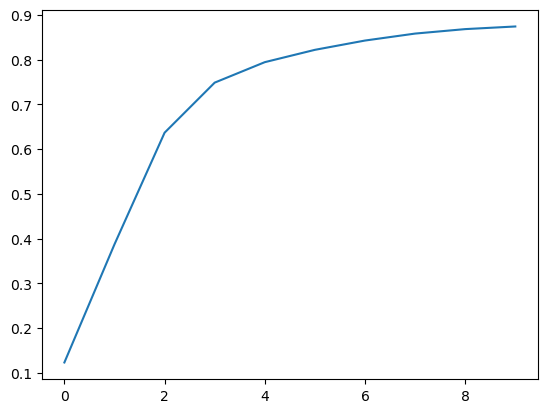

[0.12335329341317365, 0.3874251497005988, 0.6368263473053892, 0.7487025948103793, 0.7944111776447106, 0.8219560878243513, 0.8427145708582834, 0.8582834331337326, 0.8682634730538922, 0.8741516966067864]


In [13]:
import matplotlib.pyplot as plt

plt.plot(range(rounds), accuracies)
plt.show()

print(accuracies)